# COS-Holes + Literature Data Analysis

Since we are seeing a null result, we want to broaden our sample using previously published data and run some statistical analysis on the larger sample to see what kind of results it produces

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob
import astropy
from astropy.io import ascii

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 18,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 11,
          'xtick.minor.size': 7,
          'ytick.major.size': 11,
          'ytick.minor.size': 7}
plt.rcParams.update(params)

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

In [2]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')

TL;DR
- up_ch = upper limits 
- sum_df = summed values no up lims (USE FOR EVERYTHING BUT VEL PLOT) 
- com_df = comp values no up lims (USE ONLY FOR VEL PLOT)

In [3]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0


In [4]:
#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
4,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1


In [6]:
#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
com_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403,0.099,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697,0.074,80.715,17.306,-9.444,12.162,1,1
5,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1548.204,0.00051,13.855,0.052,34.300,6.220,11.655,3.925,0,1
6,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,62.794963,...,1548.204,0.00081,13.652,0.103,10.925,4.852,-2.260,2.533,0,1
7,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,29.956925,...,1548.204,0.00109,13.946,0.044,30.000,4.293,-11.070,2.849,0,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012,0.076,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211,0.053,54.100,7.973,18.210,5.687,1,1


In [7]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/Sam_COSHoles_Analysis/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

#amiga_2_det_sum

In [8]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/Sam_COSHoles_Analysis/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

In [9]:
#Borthakur 2013 Data
#https://iopscience.iop.org/article/10.1088/0004-637X/768/1/18/pdf

borthakur = pd.read_csv("/Users/samgarza/Documents/Sam_COSHoles_Analysis/borthakur_2013.csv", sep=",")   
borthakur.sort_values('det', inplace=True)
#borthakur

#remove the zero value in the df 
borthakur_no_zero = borthakur.drop(labels=12, axis=0)
#print(borthakur_no_zero)

#arrays for plotting  
civ_B13 = np.array(borthakur_no_zero['logNCIV[i]'])
civ_err_B13 = np.array(borthakur_no_zero['err'])
det_B13 = np.array(borthakur_no_zero['det'])
RpRv_B13 = np.array(borthakur_no_zero['rhokpc[i]/rvir[i]']) #Rproj/Rvir 
Rp_B13 = np.array(borthakur_no_zero['rhokpc[i]'])

In [10]:
borthakur_no_zero

,galname[i],mstar[i],alog10(mhalo[i]),rvir[i],rhokpc[i],rhokpc[i]/rvir[i],logNCIV[i],err,det
0,J075622.09+304329.0,11.02,12.784412,589.84419,193.9,0.328731,14.10,0.00,0
17,J161708.92+063822.2,11.39,13.585581,1090.91560,103.2,0.094599,14.38,0.00,0
16,J154527.12+484642.2,10.50,12.029020,330.32571,64.7,0.195867,13.79,0.00,0
15,J151136.53+402852.6,10.67,12.213995,380.71535,177.0,0.464914,14.16,0.00,0
13,J132150.89+033034.1,10.81,12.408067,441.86569,140.2,0.317291,14.06,0.00,0
18,J161913.50+334146.8,11.04,12.824801,608.41522,150.9,0.248021,13.67,0.00,0
9,J120314.43+480316.4,10.78,12.362695,426.74300,187.4,0.439140,14.14,0.00,0
6,J100801.20+500915.6,10.39,11.929875,306.12186,186.6,0.609561,13.86,0.00,0
3,J085254.99+030908.3,10.32,11.872716,292.98259,179.1,0.611299,13.75,0.00,0
2,J085252.73+031320.4,10.92,12.593102,509.29338,171.9,0.337526,14.10,0.00,0


In [11]:
#Bordoloi 2014 Data 
#https://iopscience.iop.org/article/10.1088/0004-637X/796/2/136/pdf

bordoloi = pd.read_csv("/Users/samgarza/Documents/Sam_COSHoles_Analysis/bordoloi_2014_CIV.csv", sep=",") 
bordoloi.sort_values('det', inplace=True)
#bordoloi

#arrays for plotting 
civ_B14 = np.array(bordoloi['logNCIV'])
civ_err_B14 = np.array(bordoloi['err'])
det_B14 = np.array(bordoloi['det'])
RpRv_B14 = np.array(bordoloi['R/Rvir']) #Rproj/Rvir 
Rp_B14 = np.array(bordoloi['R[kpc]'])

In [12]:
bordoloi

,QSO,logNCIV,err,det,logM*,R[kpc],Rvir[kpc],R/Rvir
21,PG1049-005,12.98,0.00,0,9.6,58,219,0.264840
23,J1451+2709,13.09,0.00,0,8.3,135,114,1.184211
24,J1342+0505,13.35,0.00,0,9.4,116,201,0.577114
25,J1211+3657,13.17,0.00,0,10.1,90,272,0.330882
26,J1121+0325,13.45,0.00,0,10.1,89,277,0.321300
27,J1001+5944,12.89,0.00,0,8.7,135,148,0.912162
28,J0155+0857,13.15,0.00,0,9.0,105,169,0.621302
29,J0310-0049,13.04,0.00,0,8.5,101,129,0.782946
30,J0242-0759,13.23,0.00,0,8.9,126,166,0.759036
22,J1521+0337,13.56,0.00,0,9.5,87,206,0.422330


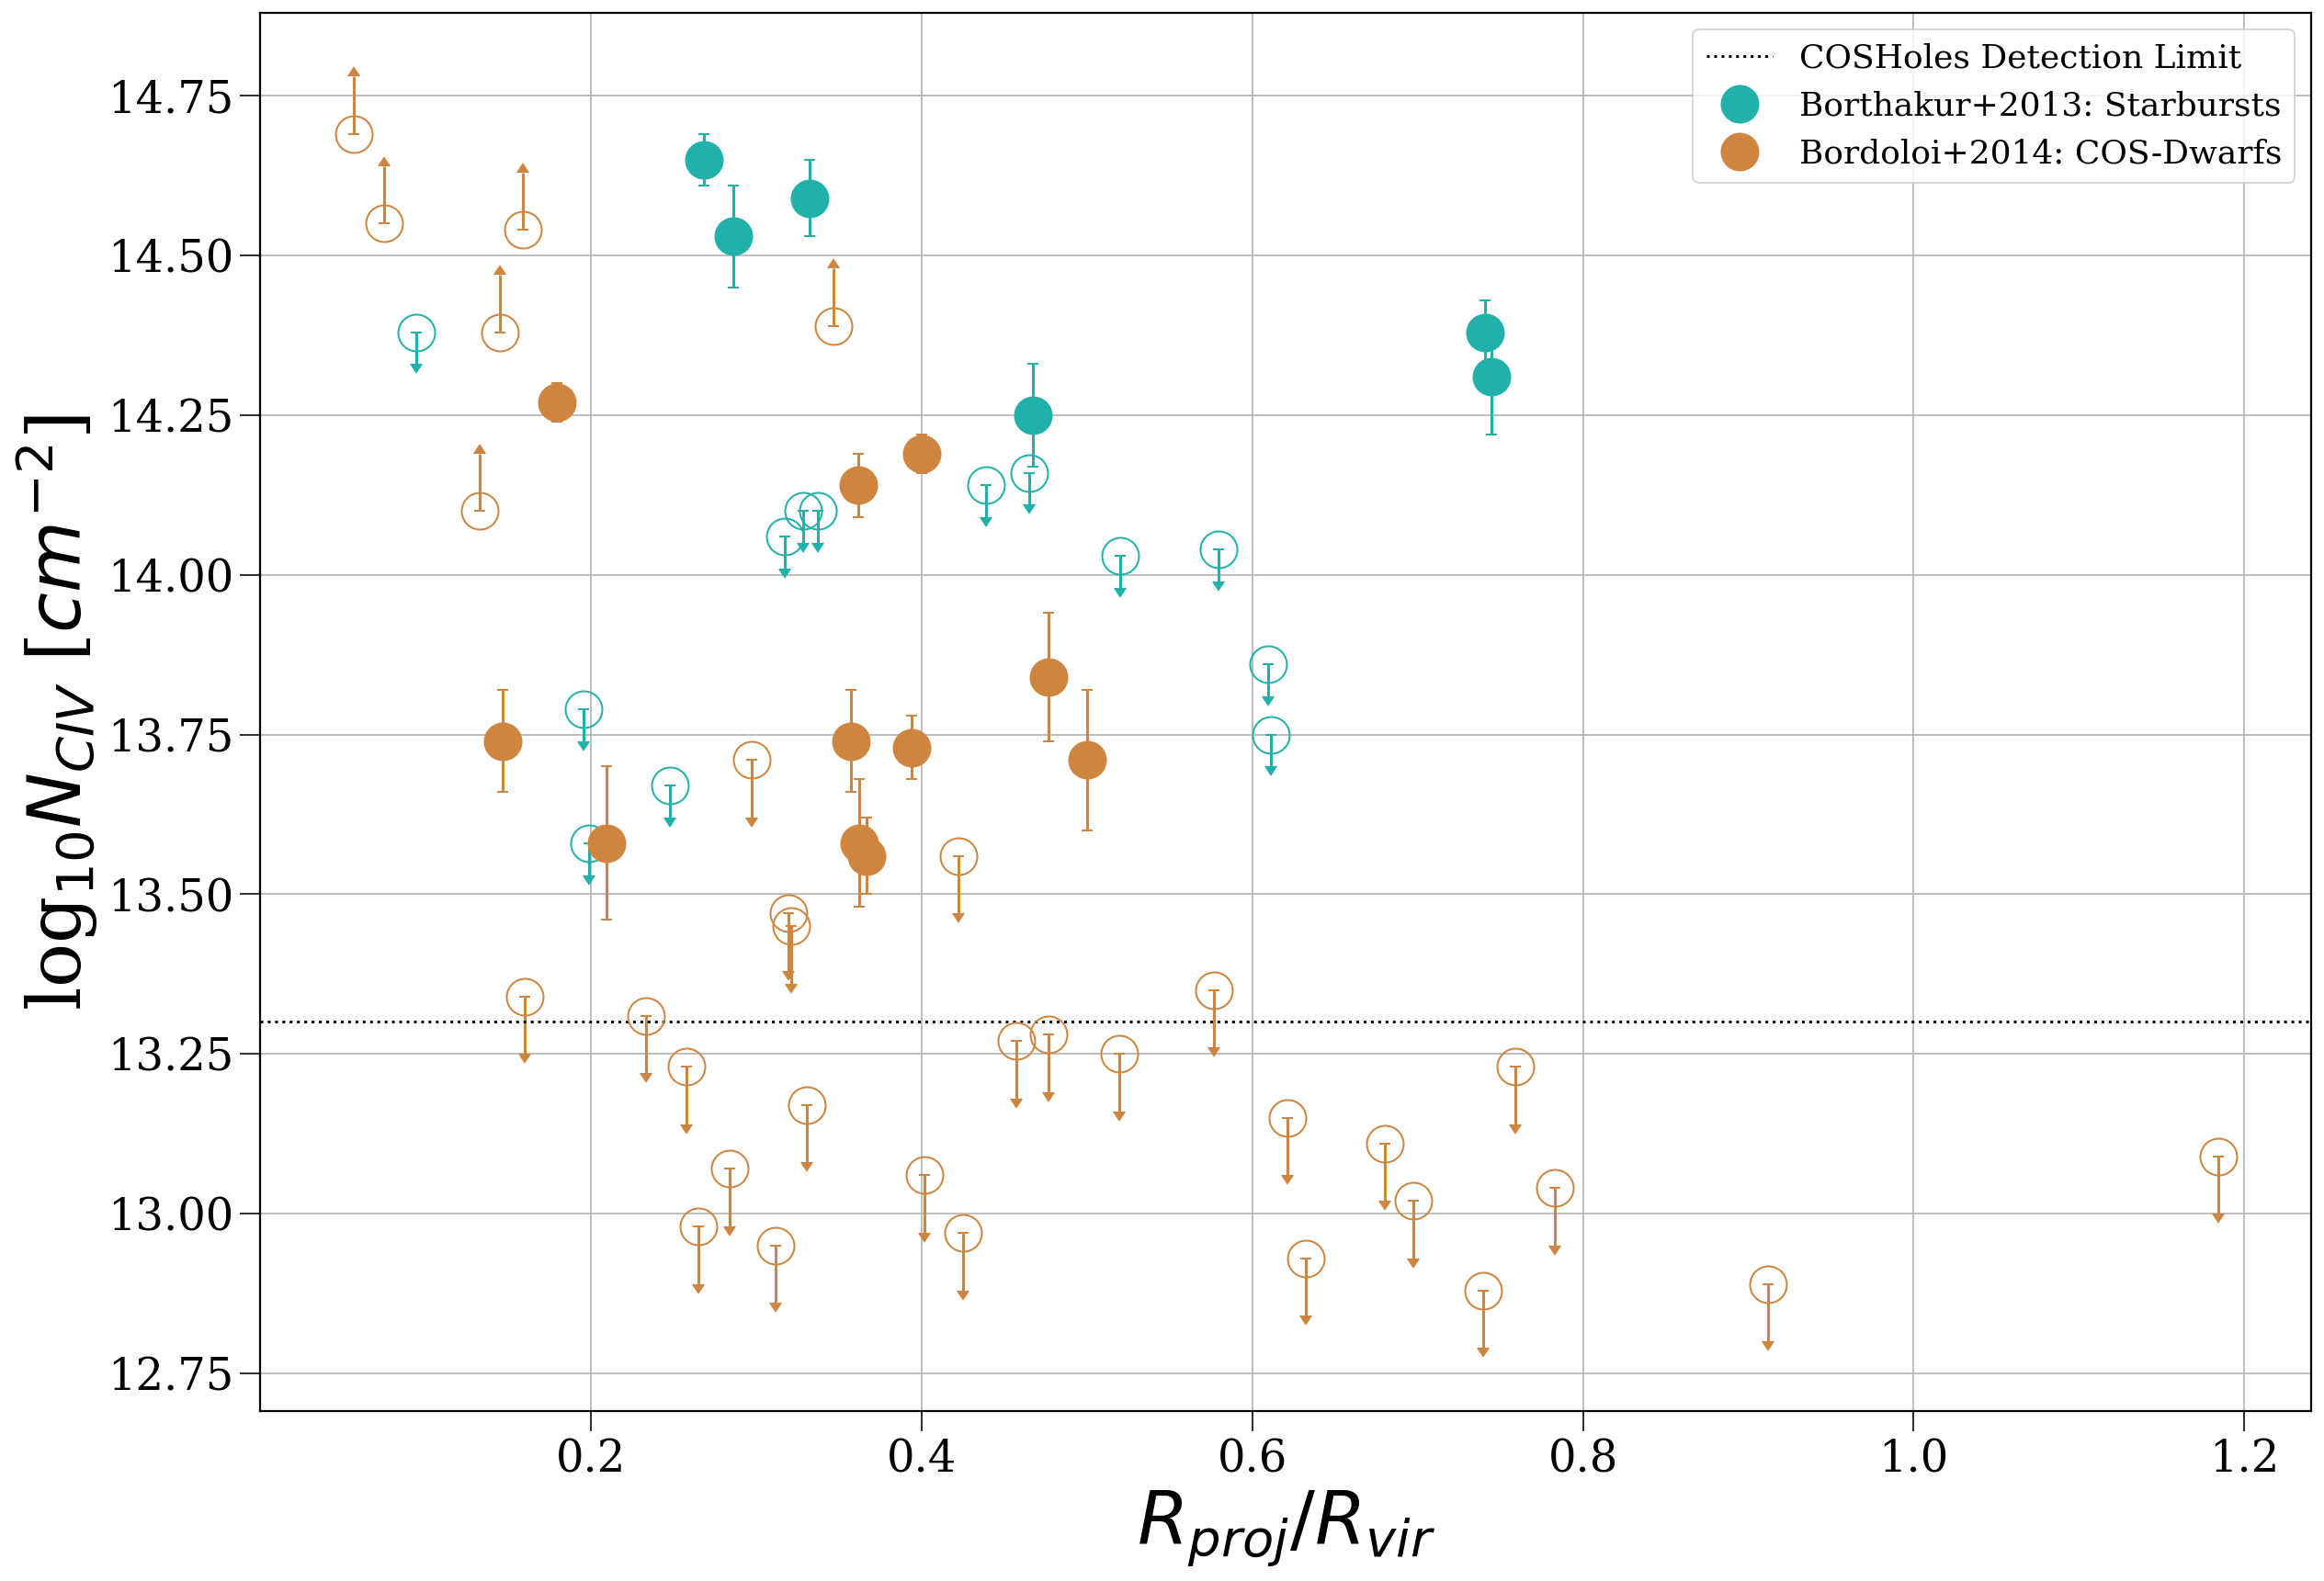

In [13]:
#Just plotting the data for fun before I start 

########Borthakur 2013
#Non-Detections
plt.errorbar(RpRv_B13[:13], civ_B13[:13], yerr = civ_err_B13[14], capsize=3, c = 'lightseagreen', 
             marker = 'o', markersize=20, ls='none', mfc='none', uplims=True)
#Detections
plt.errorbar(RpRv_B13[13:], civ_B13[13:], yerr = civ_err_B13[13:], capsize=3, c = 'lightseagreen', label = 'Borthakur+2013: Starbursts', 
             marker = 'o', markersize=20, ls='none')

#######Bordoloi 2014
#Non-Detections
plt.errorbar(RpRv_B14[:26], civ_B14[:26], yerr = civ_err_B13[15], capsize=3, c = 'peru', 
            marker = 'o', markersize = 20, ls='none', mfc='none', uplims=True)
plt.errorbar(RpRv_B14[37:], civ_B14[37:], yerr = civ_err_B13[15], capsize=3, c = 'peru', 
            marker = 'o', markersize = 20, ls='none', mfc='none', lolims=True)
#Detections
plt.errorbar(RpRv_B14[26:37], civ_B14[26:37], yerr = civ_err_B14[26:37], capsize=3, c = 'peru', label = 'Bordoloi+2014: COS-Dwarfs', 
            marker = 'o', markersize = 20, ls='none')


plt.xlabel('$R_{proj} / R_{vir}$ ')
plt.ylabel('log$_{10}N_{CIV}$ [$cm^{-2}$]')
plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')
#plt.ylim(12.6,15)
#plt.xscale("log")
plt.legend()
plt.grid(True)
plt.show()

<>:35: DeprecationWarning: invalid escape sequence \p
<>:35: DeprecationWarning: invalid escape sequence \p
<>:35: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_36893/2509557100.py:35: DeprecationWarning: invalid escape sequence \p
  marker="p", markersize=20, label='M31 (Lehner et al 2020) AOD; log$M_{BH}$ = 8.15$\pm$0.24', ls='none')


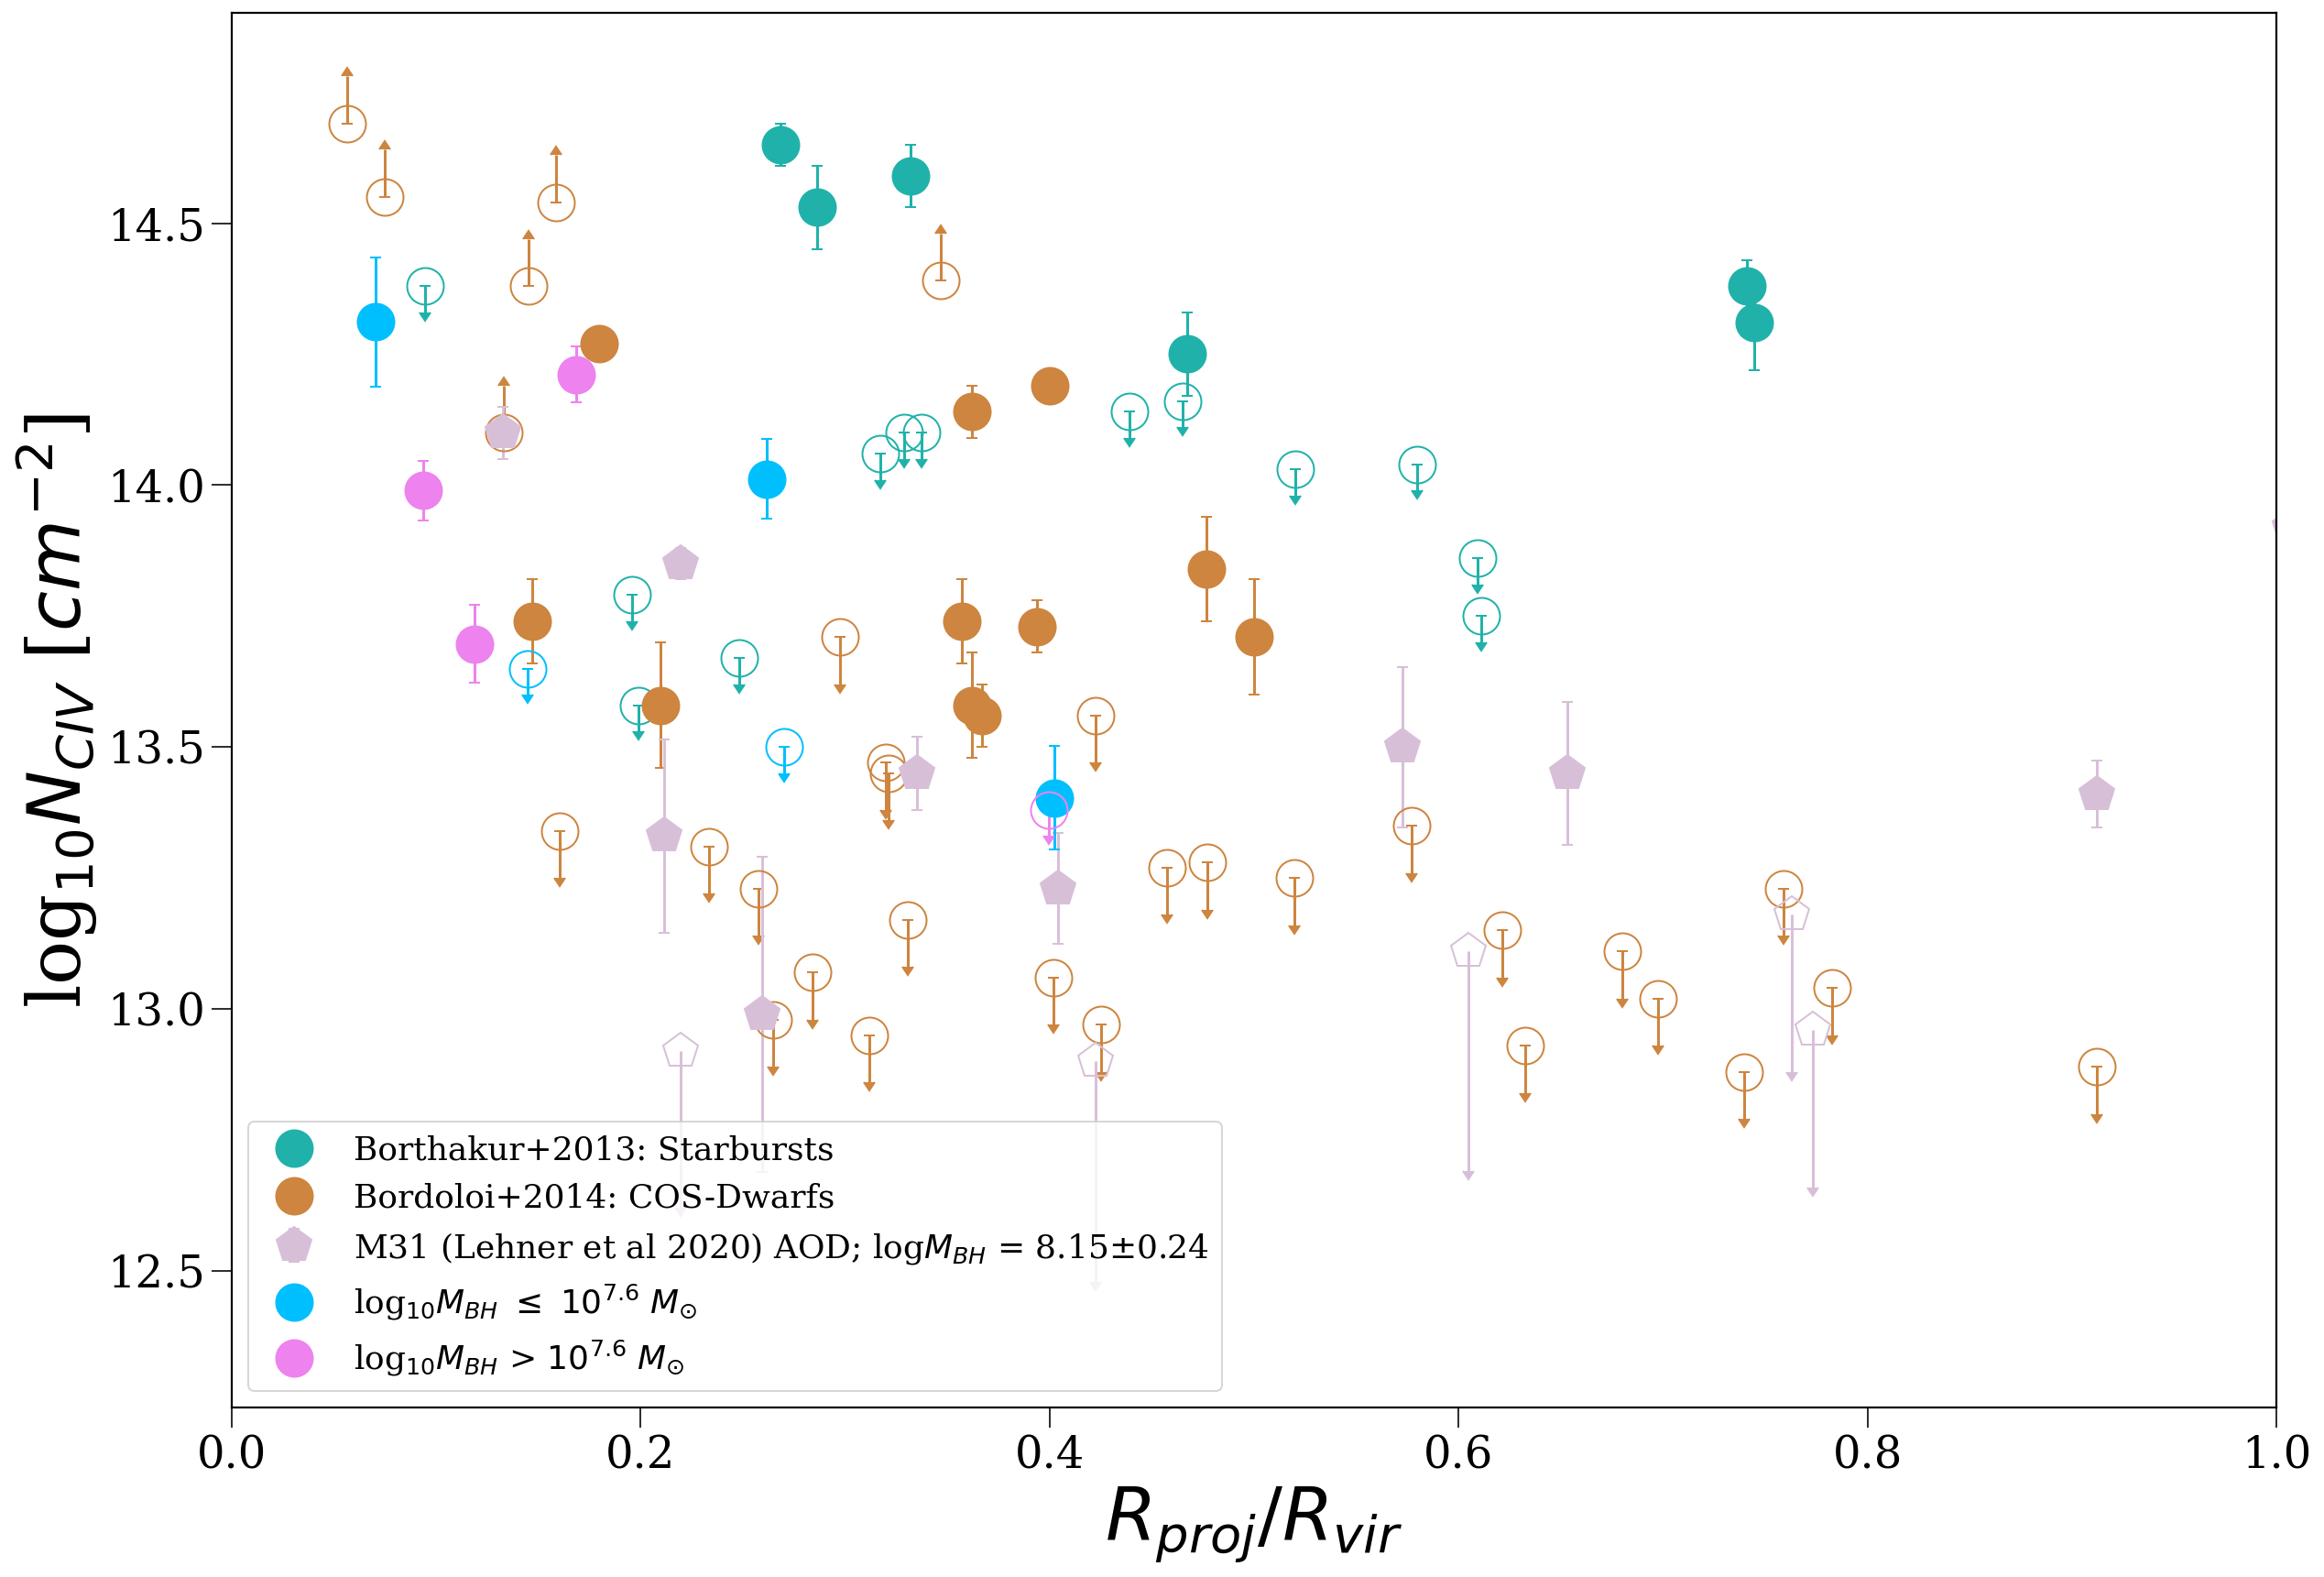

In [16]:
#Just plotting the data for fun before I start 

#creating masks to separate into high and low 
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)
    

#Plotting NCIV vs MBH    
fig, ax = plt.subplots()

########Borthakur 2013
#Non-Detections
plt.errorbar(RpRv_B13[:13], civ_B13[:13], yerr = civ_err_B13[14], capsize=3, c = 'lightseagreen', 
             marker = 'o', markersize=20, ls='none', mfc='none', uplims=True)
#Detections
plt.errorbar(RpRv_B13[13:], civ_B13[13:], yerr = civ_err_B13[13:], capsize=3, c = 'lightseagreen', label = 'Borthakur+2013: Starbursts', 
             marker = 'o', markersize=20, ls='none')

#######Bordoloi 2014
#Non-Detections
plt.errorbar(RpRv_B14[:26], civ_B14[:26], yerr = civ_err_B13[15], capsize=3, c = 'peru', 
            marker = 'o', markersize = 20, ls='none', mfc='none', uplims=True)
plt.errorbar(RpRv_B14[37:], civ_B14[37:], yerr = civ_err_B13[15], capsize=3, c = 'peru', 
            marker = 'o', markersize = 20, ls='none', mfc='none', lolims=True)
#Detections
plt.errorbar(RpRv_B14[26:37], civ_B14[26:37], yerr = civ_err_B14[26:37], capsize=3, c = 'peru', label = 'Bordoloi+2014: COS-Dwarfs', 
            marker = 'o', markersize = 20, ls='none')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = 'thistle', 
              marker="p", markersize=20, label='M31 (Lehner et al 2020) AOD; log$M_{BH}$ = 8.15$\pm$0.24', ls='none')

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = 'thistle', 
              marker="p",mfc='none',markersize=20, ls='none')

########################################################

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=3, fontsize=18)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
#ax.set_ylim(12.5, 14.6)
ax.set_xlim(0, 1)
plt.show()

### Setting up Stellar Mass Bins 

Since we are still seeing a null result I want to investigate how the stellar mass may be impacting the sample so will split the larger sample into 2 stellar mass bins and use data from 0-150 kpc (since that is where we see the most "consistency"

The bins are just gonna be 10^9-10 and 10^10-11, going to see what this looks like first and then maybe just keep up to 150 kpc 

In [17]:
####### BORTHAKUR ######### => Only has high stellar mass bin values 

borthakur_less150 = borthakur_no_zero.loc[(borthakur_no_zero['rhokpc[i]'] <= 150)]
#borthakur_less150
borthakur_high = borthakur_less150
borthakur_high

,galname[i],mstar[i],alog10(mhalo[i]),rvir[i],rhokpc[i],rhokpc[i]/rvir[i],logNCIV[i],err,det
17,J161708.92+063822.2,11.39,13.585581,1090.91560,103.2,0.094599,14.38,0.00,0
16,J154527.12+484642.2,10.50,12.029020,330.32571,64.7,0.195867,13.79,0.00,0
13,J132150.89+033034.1,10.81,12.408067,441.86569,140.2,0.317291,14.06,0.00,0
19,J230842.91-091112.8,11.09,12.928177,658.65584,131.0,0.198890,13.58,0.00,0
8,J102846.43+391842.9,10.50,12.029020,330.32571,88.7,0.268523,14.65,0.04,1
14,J140502.20+470525.9,10.43,11.964435,314.35077,146.9,0.467312,14.25,0.08,1


In [18]:
####### BORDOLOI ######### 

bordoloi_less150 = bordoloi.loc[(bordoloi['R[kpc]'] <= 150) & (bordoloi['logM*'] >= 9) ]
#bordoloi_less150

#separating into low and high sample
bordoloi_low = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 9) & (bordoloi_less150['logM*'] < 10)]
bordoloi_high = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 10)]

bordoloi_high

,QSO,logNCIV,err,det,logM*,R[kpc],Rvir[kpc],R/Rvir
25,J1211+3657,13.17,0.00,0,10.1,90,272,0.330882
26,J1121+0325,13.45,0.00,0,10.1,89,277,0.321300
1,J09525+4535,13.56,0.06,1,10.0,95,259,0.366795
15,PG1202+281,13.58,0.10,1,10.0,92,254,0.362205
12,J0959+0503,14.69,0.00,2,10.0,14,247,0.056680


In [19]:
bordoloi_low

,QSO,logNCIV,err,det,logM*,R[kpc],Rvir[kpc],R/Rvir
21,PG1049-005,12.98,0.00,0,9.6,58,219,0.264840
24,J1342+0505,13.35,0.00,0,9.4,116,201,0.577114
28,J0155+0857,13.15,0.00,0,9.0,105,169,0.621302
22,J1521+0337,13.56,0.00,0,9.5,87,206,0.422330
33,J0946+4711,13.71,0.00,0,9.6,66,222,0.297297
34,J1022+0132,13.31,0.00,0,9.1,39,167,0.233533
35,J1616+4154,13.47,0.00,0,9.2,55,172,0.319767
36,J1356+2515,13.27,0.00,0,9.6,97,212,0.457547
37,J1210+3157,13.11,0.00,0,9.3,134,197,0.680203
38,J1117+2634,13.28,0.00,0,9.8,114,239,0.476987


In [20]:
#Just bringing in the smaller data sets because they are easier to make a line through them 

#smaller df 
qso_B13 = np.array(borthakur_no_zero['galname[i]'])
mstar_B13 = np.array(borthakur_no_zero['mstar[i]'])

borthakur_smol= pd.DataFrame({"QSOname":qso_B13, "Smass":mstar_B13, "Rproj":Rp_B13, "CIVN":civ_B13, "CIVsigN":civ_err_B13})
borthakur_smol

,QSOname,Smass,Rproj,CIVN,CIVsigN
0,J075622.09+304329.0,11.02,193.9,14.10,0.00
1,J161708.92+063822.2,11.39,103.2,14.38,0.00
2,J154527.12+484642.2,10.50,64.7,13.79,0.00
3,J151136.53+402852.6,10.67,177.0,14.16,0.00
4,J132150.89+033034.1,10.81,140.2,14.06,0.00
5,J161913.50+334146.8,11.04,150.9,13.67,0.00
6,J120314.43+480316.4,10.78,187.4,14.14,0.00
7,J100801.20+500915.6,10.39,186.6,13.86,0.00
8,J085254.99+030908.3,10.32,179.1,13.75,0.00
9,J085252.73+031320.4,10.92,171.9,14.10,0.00


In [21]:
#smaller df

qso_B14 = np.array(bordoloi['QSO'])
mstar_B14 = np.array(bordoloi['logM*'])

bordoloi_smol= pd.DataFrame({"QSOname":qso_B14, "Smass":mstar_B14, "Rproj":Rp_B14, "CIVN":civ_B14, "CIVsigN":civ_err_B14})
bordoloi_smol

,QSOname,Smass,Rproj,CIVN,CIVsigN
0,PG1049-005,9.6,58,12.98,0.00
1,J1451+2709,8.3,135,13.09,0.00
2,J1342+0505,9.4,116,13.35,0.00
3,J1211+3657,10.1,90,13.17,0.00
4,J1121+0325,10.1,89,13.45,0.00
5,J1001+5944,8.7,135,12.89,0.00
6,J0155+0857,9.0,105,13.15,0.00
7,J0310-0049,8.5,101,13.04,0.00
8,J0242-0759,8.9,126,13.23,0.00
9,J1521+0337,9.5,87,13.56,0.00


In [22]:
lit_data = pd.concat([borthakur_smol, bordoloi_smol])
lit_data

,QSOname,Smass,Rproj,CIVN,CIVsigN
0,J075622.09+304329.0,11.02,193.9,14.10,0.0
1,J161708.92+063822.2,11.39,103.2,14.38,0.0
2,J154527.12+484642.2,10.50,64.7,13.79,0.0
3,J151136.53+402852.6,10.67,177.0,14.16,0.0
4,J132150.89+033034.1,10.81,140.2,14.06,0.0
...,...,...,...,...,...
38,J0826+0742,9.70,77.0,14.39,0.0
39,J0959+0503,10.00,14.0,14.69,0.0
40,J1236+2641,9.40,28.0,14.38,0.0
41,J0042+1037,9.60,15.0,14.55,0.0


In [ ]:
##### CIV #####

XX =  np.copy(CIVDF['Rproj']/CIVDF['Rvir']) #Getting the impact parameter from my galaxy parameters table 
YY = np.copy(CIVDF["CIVN"]) #getting the column density of CIV from main data table 
YY_err = np.copy(CIVDF["CIVsigN"]) #column density error of CIV 
has_UL = YY_err < 0 #determining the ones that have upper limts (in his table they are denoted with -1 in the error column) T/F

Ylim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)
Ylim[has_UL] = 1 #if this array has a -1 values (upper limit) then it is given the value of 1 
Xlim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)

coeff = "kendallt" # the correlation coefficient 
Nboot = 10_000 #number of bootstrapping iterations over which the uncertainties are estimated 

xCrr = XX #same as XX => impact parameters 
yCrr = YY #same as YY => column densities 
yCrr_err = YY_err #same as YY_err => column density error 
xlimCrr = Xlim #array of 0s same length as XX or Xlim 
ylimCrr = Ylim #array od 0s and 1s same length as YY or Ylim (1 if it is an upper limit)

kwargs = {"return_dist":True}
res = pymccorrelation(xCrr, yCrr, xlim = xlimCrr, ylim = ylimCrr, coeff = coeff, Nboot = Nboot, **kwargs)

outCrr = {} #Where the stat information is stored 

outCrr["coeff_percentiles"] = res[0]
outCrr["p-value_percentiles"] = res[1]
outCrr["coeff_dist"] = res[2]
outCrr["p-value_dist"] = res[3]

mc_datarr = {
    "Ion":["CIV"]*len(outCrr["coeff_dist"]),
    r"Kendall's $\tau$":outCrr["coeff_dist"],
    r"$\log_{10}$(p-value)":np.log10(outCrr["p-value_dist"])
}